# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [73]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

    100% |████████████████████████████████| 276kB 14.9MB/s ta 0:00:01
    100% |████████████████████████████████| 174kB 21.2MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 23.6MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 19.0MB/s ta 0:00:01
    100% |████████████████████████████████| 9.0MB 10.2MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 12.1MB/s ta 0:00:01


In [7]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
# import sagemaker
# import boto3

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
from PIL import Image
from IPython.display import display



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline




Start with initial data analysis: what do the images look like? How large are the images?

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [8]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

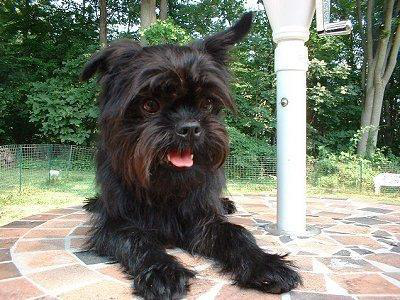

In [9]:
test_path = "./dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg"

with Image.open(test_path) as im:
    display(im)



In [10]:
path = './dogImages/'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
    
        
print('Images: ',len(img_names))



Images:  8351


In [11]:
class DataInspectTools():

    def __init__(self, path):
        self.path = path


    def get_image_names(self):
        '''Returns the names of the images in all subfolders within path'''
        img_names = []
        for folder, subfolders, filenames in os.walk(path):
            for img in filenames:
                img_names.append(folder+'/'+img)
        return img_names

   
    def display_image_sizes(self):
        '''Display statistics of image sizes in data'''
        img_names = self.get_image_names()
        img_sizes = []
        rejected = []

        for item in img_names:
            try:
                with Image.open(item) as img:
                    img_sizes.append(img.size)
            except:
                rejected.append(item)
                
        print(f'Images:  {len(img_sizes)}')
        print(f'Rejects: {len(rejected)}')
        df = pd.DataFrame(img_sizes, columns=['width','length'])
        display(df.describe())


    def set_transforms(self):
        self.train_transform = transforms.Compose([
            transforms.RandomRotation(10),      # rotate +/- 10 degrees
            transforms.RandomHorizontalFlip(),  # reverse 50% of images
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])
        ])



        


path = './dogImages/'
d = DataInspectTools(path)
d.display_image_sizes()



Images:  8351
Rejects: 0


,width,length
count,8351.000000,8351.000000
mean,567.032571,529.044905
std,389.006647,333.197594
min,105.000000,113.000000
25%,375.000000,360.000000
50%,500.000000,467.000000
75%,640.000000,600.000000
max,4278.000000,4003.000000


In [12]:
# Start by creating a list
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  8351
Rejects: 0


In [13]:
df = pd.DataFrame(img_sizes)

df.describe

<bound method NDFrame.describe of         0    1
0     314  320
1     406  450
2     300  380
3     500  500
4     375  500
5     500  375
6     264  279
7     640  480
8     484  500
9     400  341
10    450  600
11    800  534
12    626  802
13    800  600
14    270  377
15    600  535
16    358  432
17    600  450
18    200  250
19    600  800
20    450  600
21    426  640
22    640  591
23    346  551
24    470  370
25    800  500
26    250  374
27    636  424
28    800  531
29    524  750
...   ...  ...
8321  800  600
8322  435  498
8323  530  358
8324  300  246
8325  395  516
8326  300  300
8327  360  500
8328  401  500
8329  640  480
8330  417  446
8331  340  360
8332  635  426
8333  500  333
8334  640  429
8335  640  480
8336  500  334
8337  480  375
8338  300  372
8339  480  640
8340  400  393
8341  448  336
8342  639  434
8343  480  640
8344  640  435
8345  640  427
8346  600  449
8347  640  427
8348  640  425
8349  500  300
8350  424  579

[8351 rows x 2 columns]>

In [14]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
001.Affenpinscher
Image before transform (size (314, 320))


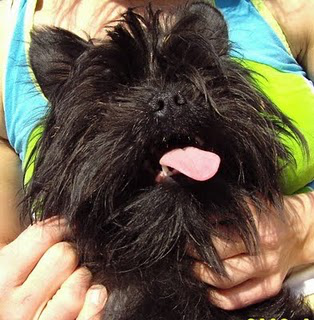

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image after transform (size torch.Size([3, 224, 224]))


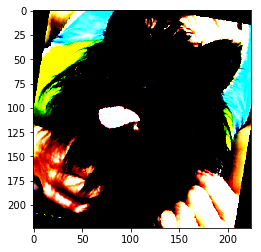

In [15]:
from torch.utils.data import Dataset


class CustomDataSet(Dataset):

    def __init__(self, path, transform):
        self.root = path
        self.transform = transform
        self.img_paths, self.img_class, self.img_class_int = self._get_image(path)
        # self.img_class_int = self._get_class_indexes()
    
    # def _get_class_indexes(self):
    #     '''Convert the classes to integers'''
    #     unique_classes = list(np.unique(self.img_class))
    #     return [unique_classes.index(c) for c in self.img_class]
        
    

    def _get_image(self,path):
        '''Returns the names of the images in all subfolders within path'''
        img_loc = []
        img_class = []
        img_class_int = []
        i = -1 
        for folder, subfolders, filenames in os.walk(path):
            for img in filenames:
                img_loc.append(folder+'/'+img)
                img_class.append(folder.split("/")[-1])
                img_class_int.append(i)
            i+=1
        return img_loc, img_class, img_class_int

    def __len__(self):
        return len(self.img_paths)


    def __getitem__(self, idx):
        img_loc = os.path.join(self.img_paths[idx])
        target_class = self.img_class_int[idx]
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, target_class

    def _plot_tensor(self, img):
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)));

    def test_transform(self,idx = 0):
        img_loc = os.path.join(self.img_paths[idx])
        image = Image.open(img_loc).convert("RGB")
        print(f'Image before transform (size {image.size})')
        display(image)
        tensor_image = self.transform(image)
        print(f'Image after transform (size {tensor_image.size()})')
        self._plot_tensor(tensor_image)

    def get_class_names(self):
        return list(np.unique(self.img_class))

    def get_labels(self):
        return list(np.unique(self.img_class_int))



test = CustomDataSet("./dogImages/test/", train_transform)
print(test.img_paths[0])
print(test.img_class[0])

test.test_transform(0)

In [25]:
torch.cuda.is_available()

False

In [26]:
root = './dogImages/'
seed = 41 #VO
torch.manual_seed(seed)

train_data = CustomDataSet(os.path.join(root, 'train'), transform=train_transform)
valid_data = CustomDataSet(os.path.join(root, 'valid'), transform=test_transform)
test_data = CustomDataSet(os.path.join(root, 'test'), transform=test_transform)

if(torch.cuda.is_available()):
    train_loader = DataLoader(train_data, batch_size=10, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_data, batch_size=10, shuffle=True, pin_memory=True)
    test_data = DataLoader(valid_data, batch_size=10, shuffle=True, pin_memory=True)
else:
    train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=10, shuffle=True)
    test_data = DataLoader(valid_data, batch_size=10, shuffle=True)

In [17]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels)
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Label: tensor([ 89,  83,  63,  71, 107,  54, 129,   6,  61,   7])


NameError: name 'class_names' is not defined

In [18]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

    def count_parameters(self):
        '''Returns the number of parameters to estimate in each layer'''
        params = [p.numel() for p in self.parameters() if p.requires_grad]
        for item in params:
            print(f'{item:>8}')
        print(f'________\n{sum(params):>8}')


In [19]:
torch.manual_seed(seed)
CNNmodel = ConvolutionalNetwork(133)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=133, bias=True)
)

In [20]:
CNNmodel.count_parameters()

     162
       6
     864
      16
 5598720
     120
   10080
      84
   11172
     133
________
 5621357


In [154]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

        for i in range(epochs):
            trn_corr = 0
            tst_corr = 0
            
            # Run the training batches
            for b, (X_train, y_train) in enumerate(train_loader):
                
                # Limit the number of batches
                if b == max_trn_batch:
                    break
                b+=1
                
                # Apply the model
                y_pred = CNNmodel(X_train)
                loss = criterion(y_pred, y_train)
        
                # Tally the number of correct predictions
                predicted = torch.max(y_pred.data, 1)[1]
                batch_corr = (predicted == y_train).sum()
                trn_corr += batch_corr
                
                # Update parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print interim results
                if b%200 == 0:
                    print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
        accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

            train_losses.append(loss)
            train_correct.append(trn_corr)

            # Run the testing batches
            with torch.no_grad():
                for b, (X_test, y_test) in enumerate(test_loader):
                    # Limit the number of batches
                    if b == max_tst_batch:
                        break

                    # Apply the model
                    y_val = CNNmodel(X_test)

                    # Tally the number of correct predictions
                    predicted = torch.max(y_val.data, 1)[1] 
                    tst_corr += (predicted == y_test).sum()

            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

: 

In [24]:
class ModelTrainer():
    
    def __init__(self, 
                 model,
                 criterion,
                 optimizer,
                 epochs,
                 max_trn_batch,
                 max_tst_batch,
                 train_loader,
                 valid_loader            
                 
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs

        #To limit the number of batches
        self.max_trn_batch = max_trn_batch
        self.max_tst_batch = max_tst_batch

        self.train_loader = train_loader
        self.valid_loader = valid_loader

        self.train_losses = []
        self.test_losses = []
        self.train_correct = []
        self.test_correct = []

        self.run_model()


    def run_model(self):
        for i in range(self.epochs):
            self.train_model()
            self.test_model()

    def train_model(self):
        trn_corr = 0
        # Run the training batches
        for b, (X_train, y_train) in enumerate(self.train_loader):
            
            # Limit the number of batches
            if b == max_trn_batch:
                break
            b+=1
            
            # Apply the model
            y_pred = self.model(X_train)
            loss = self.criterion(y_pred, y_train)
    
            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr
            
            # Update parameters
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Print interim results
            if b%200 == 0:
                print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
                accuracy: {trn_corr.item()*100/(10*b):7.3f}%')  
        
        self.train_losses.append(loss)
        self.train_correct.append(trn_corr)      

    def test_model(self):
        tst_corr = 0

        # Run the testing batches
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(self.valid_loader):
                # Limit the number of batches
                if b == self.max_tst_batch:
                    break

                # Apply the model
                y_val = self.model(X_test)

                # Tally the number of correct predictions
                predicted = torch.max(y_val.data, 1)[1] 
                tst_corr += (predicted == y_test).sum()

        loss = self.criterion(y_val, y_test)
        self.test_losses.append(loss)
        self.test_correct.append(tst_corr)



CNNmodel = ConvolutionalNetwork(133)

if(torch.cuda.is_available()):
    CNNmodel = CNNmodel.cuda()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
epochs = 3
max_trn_batch = 800
max_tst_batch = 300

# trained_model = ModelTrainer(
#                  model=CNNmodel,
#                  criterion=criterion,
#                  optimizer=optimizer,
#                  epochs=epochs,
#                  max_trn_batch=max_trn_batch,
#                  max_tst_batch=max_tst_batch,
#                  train_loader=train_loader,
#                  valid_loader=valid_loader           
#                  )

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.

In [ ]:
#TODO: Create estimators for your HPs

estimator = # TODO: Your estimator here

tuner = # TODO: Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit() # TODO: Remember to include your data channels

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()